<a href="https://colab.research.google.com/github/MarioJorgeGoncalves/CODIGOS_LIDAR/blob/main/Dados_Lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install laspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install geocube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.5.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.0
    Uninstalling Pillow-9.0.0:
      Successfully uninstalled Pillow-9.0.0


In [ ]:
!pip install rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [338]:
import matplotlib.pyplot as plt
#from PIL import Image # converter a imagem para diferentes formatos e modos de cor, aplicar filtros, entre outros.
import numpy as np
import pandas as pd
import open3d as o3d
import laspy
from collections import Counter
import rioxarray as riox
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Polygon
# Verificar Geometrias do buffer e da TIF
import rasterio
import rasterio.plot

In [ ]:
# Leitura pelo Laspy
path='/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/000017.las'
las = laspy.read(path)


In [ ]:
# Filtrar a nuvem de pontos LiDAR pela categoria 1 - UNCLASSIFIED
unclassified = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
unclassified.points = las.points[las.classification == 1]

In [ ]:
# Filtrar a nuvem de pontos LiDAR pela categoria 2 - GROUND
ground = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
ground.points = las.points[las.classification == 2]

In [ ]:
# Dados Gerais da Nuvem de pontos LiDAR
las
las.header
las.header.point_format # 3 dimensões
las.header.point_count # total de pontos das 2 categorias LiDAR

1349155

In [ ]:
# Acessando o array de classificação
pontos_classificados = las.points['classification']
# Contando o número de pontos em cada categoria
contagem_pontos = Counter(pontos_classificados)
contagem_pontos

Counter({2: 243720, 1: 1105435})

In [ ]:
# Imprime as dimensões da nuvem de pontos e da variação da elevação dentro desta peça LiDAR (GROUND+UNCLASSIFIED)
print(f'Número de pontos: {len(las)}')
print(f'Dimensão X: {las.header.min[0]} - {las.header.max[0]}')
print(f'Dimensão Y: {las.header.min[1]} - {las.header.max[1]}')
print(f'Dimensão Z: {las.header.min[2]} - {las.header.max[2]}')

Número de pontos: 1349155
Dimensão X: 1159500.0 - 1159999.99
Dimensão Y: 1030500.0 - 1030999.99
Dimensão Z: 1651.13 - 1786.8


In [ ]:
# Categorias da nuvem de pontos LiDAR
set(list(las.classification))

{1, 2}

In [ ]:
# Lista de características da nuvem de pontos LiDAR
list(las.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue']

In [ ]:
# As coordenadas e a elevação apresentam valores inteiros (normalmente apresentada em valores discretos)
las.X
las.Y
las.Z

array([166467, 166460, 166490, ..., 166683, 167544, 167612], dtype=int32)

In [ ]:
# Apresentar as coordenadas X e Y e a elevação Z da nuvem de pontos LiDAR
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1,0))
point_data

array([[115999747, 103099954,    166467],
       [115999685, 103099913,    166460],
       [115999655, 103099967,    166490],
       ...,
       [115999799, 103050137,    166683],
       [115999894, 103050073,    167544],
       [115999930, 103050017,    167612]], dtype=int32)

In [ ]:
# X, Y e Z apresentam valores inteiros-converter para float aplicando um fator de escala e um deslocamento (offset)
# conversão de coordenadas em float para todos os pontos das 2 categorias

## ----------------------------All points------------------------------------
xxx = las.X * las.header.scale[0] + las.header.offset[0]
yyy = las.Y * las.header.scale[1] + las.header.offset[1]
zzz = las.Z * las.header.scale[2] + las.header.offset[2]


## ---------------------------Ground points--------------------------------
x = ground.points.X * ground.header.scale[0] + ground.header.offset[0]
y = ground.points.Y * ground.header.scale[1] + ground.header.offset[1]
z = ground.points.Z * ground.header.scale[2] + ground.header.offset[2]

##----------------------------UNCLASSIFIED POINTS---------------------------
xx = unclassified.points.X * unclassified.header.scale[0] + unclassified.header.offset[0]
yy = unclassified.points.Y * unclassified.header.scale[1] + unclassified.header.offset[1]
zz = unclassified.points.Z * unclassified.header.scale[2] + unclassified.header.offset[2]

In [ ]:
len(xxx)

1349155

In [ ]:
len(x)

243720

In [ ]:
len(xx)

1105435

In [ ]:
# Plotar a nuvem de pontos em 3D DAS 2 CATEGORIAS
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(las.x, las.y, las.z, s=0.5, c=las.z) # visualização das coordenadas x,y,z , s é o tamanho do ponto e c a tonalidade em função de z (elevação)
ax.set_xlabel("COORDENADA X")
ax.set_ylabel("COORDENADA Y")
ax.set_zlabel("ELEVAÇÃO Z")
ax.set_title("Nuvem de pontos em 3D - 2 CATEGORIAS")
# Mostrar o gráfico
plt.show()

In [ ]:
# Plotar a nuvem de pontos em 3D EM FUNÇÃO DA CATEGORIA GROUND (3D PARA CONSTRUÇÃO DE DTM)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ground.points.x, ground.points.y, ground.points.z, s=0.5, c=ground.points.z) # visualização das coordenadas x,y,z , s é o tamanho do ponto e c a tonalidade em função de z (elevação)
ax.set_xlabel("COORDENADA X")
ax.set_ylabel("COORDENADA Y")
ax.set_zlabel("ELEVAÇÃO Z")
ax.set_title("Nuvem de pontos em 3D -MODELO DTM")
# Mostrar o gráfico
plt.show()



In [ ]:
# Plotar a nuvem de pontos em 3D EM FUNÇÃO DA CATEGORIA UNCLASSIFIED (3D PARA CONSTRUÇÃO DE DSM)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(unclassified.points.x, unclassified.points.y, unclassified.points.z, s=0.5, c=unclassified.points.z) # visualização das coordenadas x,y,z , s é o tamanho do ponto e c a tonalidade em função de z (elevação)
ax.set_xlabel("COORDENADA X")
ax.set_ylabel("COORDENADA Y")
ax.set_zlabel("ELEVAÇÃO Z")
ax.set_title("Nuvem de pontos em 3D -MODELO DSM")
# Mostrar o gráfico
plt.show()

CONSTRUÇÃO DE RASTER FILE GROUND AND UNCLASSIFIED AND BOTH UTILIZANDO A NUVEM DE PONTOS 17

In [ ]:
# Creates a geoseries for the point geometries in the pointcloud (BOTH)
#sss = gpd.GeoSeries(map(geometry.Point, zip(xxx, yyy))) # zip une as listas x e y de coordenadas
#sss

In [ ]:
# Creates a geoseries for the point geometries in the pointcloud (GROUND)
s = gpd.GeoSeries(map(geometry.Point, zip(x, y))) # zip une as listas x e y de coordenadas
s

In [ ]:
# Creates a geoseries for the point geometries in the pointcloud (UNCLASSIFIED)
s1 = gpd.GeoSeries(map(geometry.Point, zip(xx, yy))) # zip une as listas x e y de coordenadas
s1

In [ ]:
# Creates a geodataframe for storing altitudes - BOTH
#gdfss = gpd.GeoDataFrame(data={'Altitude':zzz}, geometry=sss, crs='EPSG:3115') # une a altitude às listas de coordenadas. EPSG:NÂO FUNCIONA!
# Reprojetar o GeoDataFrame para EPSG:4326 (WGS 84)
#gdfss = gdfss.to_crs('EPSG:32618')
#gdfss

In [ ]:
# Creates a geodataframe for storing altitudes - GROUND
gdf = gpd.GeoDataFrame(data={'Altitude':z}, geometry=s, crs='EPSG:3115') # une a altitude às listas de coordenadas. EPSG:NÂO FUNCIONA!
# Reprojetar o GeoDataFrame para EPSG:4326 (WGS 84)
#gdf = gdf.to_crs('EPSG:32618')
gdf

In [ ]:
# Creates a geodataframe for storing altitudes - UNCLASSIFIED
gdf1 = gpd.GeoDataFrame(data={'Altitude':zz}, geometry=s1, crs='EPSG:3115') # une a altitude às listas de coordenadas. EPSG:NÂO FUNCIONA!
# Reprojetar o GeoDataFrame para EPSG:4326 (WGS 84)
#gdf1 = gdf1.to_crs('EPSG:32618')
gdf1

In [ ]:
#BOTH
# Creates a 500x500 grid of 1x1 meter square polygons, AOI, criar uma grade de polígonos regulares com um tamanho específico em uma determinada área geográfica.
#xmin, ymin, xmax, ymax = gdfss.total_bounds # extrai as coordenadas do square

#length = 1 # resolução espacial xy do pixel
#wide = 1

# A função np.arange é usada para criar uma sequência de valores de coordenadas, começando em xmin (ou ymin) e indo até xmax (ou ymax) com incrementos de wide (ou length)
#cols = list(np.arange(xmin, xmax + wide, wide))
#rows = list(np.arange(ymin, ymax + length, length))

#polygons = [] # essa linha cria uma lista vazia para armazenar os polígonos da grade.
#for x in cols[:-1]: #criam uma lista de polígonos retangulares regulares ao percorrer todas as posições da grade definidas por cols e rows. Para cada posição, é criado um polígono retangular com quatro vértices, usando as coordenadas da posição atual e adicionando o tamanho da grade para definir os vértices do polígono. O resultado é uma lista de objetos Polygon da biblioteca shapely.geometry, que serão usados para criar um novo GeoDataFrame.
#    for y in rows[:-1]:
#        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

#gridss = gpd.GeoDataFrame({'geometry':polygons}, crs='EPSG:32618') # cria um novo GeoDataFrame chamado grid com uma única coluna geometry que contém a lista de polígonos polygons
# grid.to_file("grid.shp")
#gridss

In [ ]:
#GROUND
# Creates a 500x500 grid of 1x1 meter square polygons, AOI, criar uma grade de polígonos regulares com um tamanho específico em uma determinada área geográfica.
xmin, ymin, xmax, ymax = gdf.total_bounds # extrai as coordenadas do square

length = 1 # resolução espacial xy do pixel
wide = 1

# A função np.arange é usada para criar uma sequência de valores de coordenadas, começando em xmin (ou ymin) e indo até xmax (ou ymax) com incrementos de wide (ou length)
cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = [] # essa linha cria uma lista vazia para armazenar os polígonos da grade.
for x in cols[:-1]: #criam uma lista de polígonos retangulares regulares ao percorrer todas as posições da grade definidas por cols e rows. Para cada posição, é criado um polígono retangular com quatro vértices, usando as coordenadas da posição atual e adicionando o tamanho da grade para definir os vértices do polígono. O resultado é uma lista de objetos Polygon da biblioteca shapely.geometry, que serão usados para criar um novo GeoDataFrame.
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons}, crs='EPSG:3115') # cria um novo GeoDataFrame chamado grid com uma única coluna geometry que contém a lista de polígonos polygons
# grid.to_file("grid.shp")
grid

In [ ]:
# MUDAR DE PROJEÇÃO PARA EPSG: 32618
gdf = gdf.to_crs('EPSG:32618') #GROUND
grid=grid.to_crs('EPSG:32618') #GROUND

In [ ]:
#UNCLASSIFIED
# Creates a 500x500 grid of 1x1 meter square polygons, AOI, criar uma grade de polígonos regulares com um tamanho específico em uma determinada área geográfica.
xmin, ymin, xmax, ymax = gdf1.total_bounds # extrai as coordenadas do square

length = 1 # resolução espacial xy do pixel
wide = 1

# A função np.arange é usada para criar uma sequência de valores de coordenadas, começando em xmin (ou ymin) e indo até xmax (ou ymax) com incrementos de wide (ou length)
cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = [] # essa linha cria uma lista vazia para armazenar os polígonos da grade.
for x in cols[:-1]: #criam uma lista de polígonos retangulares regulares ao percorrer todas as posições da grade definidas por cols e rows. Para cada posição, é criado um polígono retangular com quatro vértices, usando as coordenadas da posição atual e adicionando o tamanho da grade para definir os vértices do polígono. O resultado é uma lista de objetos Polygon da biblioteca shapely.geometry, que serão usados para criar um novo GeoDataFrame.
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid1 = gpd.GeoDataFrame({'geometry':polygons}, crs='EPSG:3115') # cria um novo GeoDataFrame chamado grid com uma única coluna geometry que contém a lista de polígonos polygons
# grid.to_file("grid.shp")
grid1

In [ ]:
# MUDAR DE PROJEÇÃO PARA EPSG: 32618
gdf1 = gdf1.to_crs('EPSG:32618') #UNCLASSIFIED
grid1=grid1.to_crs('EPSG:32618') # UNCLASSIFIED

In [ ]:
#BOTH
# Merges the grid with the pointcloud (section points into the square grid)
#mergedss = gridss.sjoin(gdfss, how="left", predicate='intersects')
#mergedss # quais os pontos que estão dentro de cada pixel quadrado

In [ ]:
#GROUND
# Merges the grid with the pointcloud (section points into the square grid)
merged = grid.sjoin(gdf, how="left", predicate='intersects')
merged # quais os pontos que estão dentro de cada pixel quadrado

In [ ]:
#UNCLASSIFIED
# Merges the grid with the pointcloud (section points into the square grid)
merged1 = grid1.sjoin(gdf1, how="left", predicate='intersects')
merged1 # quais os pontos que estão dentro de cada pixel quadrado

In [ ]:
#BOTH
# Get mean altitude of points inside each square
#group_mergess = mergedss.groupby(mergedss.index).max()
#group_mergess.drop(columns=['index_right'],inplace=True)
#group_mergess #média de pontos e o pixel fica associado com a média da elevação dos pontos dentro de cada pixel

In [ ]:
#GROUND
# Get mean altitude of points inside each square
group_merge = merged.groupby(merged.index).max()
group_merge.drop(columns=['index_right'],inplace=True)
group_merge #média de pontos e o pixel fica associado com a média da elevação dos pontos dentro de cada pixel

In [ ]:
#UNCLASSIFIED
# Get mean altitude of points inside each square
group_merge1 = merged1.groupby(merged1.index).max()
group_merge1.drop(columns=['index_right'],inplace=True)
group_merge1 #média de pontos e o pixel fica associado com a média da elevação dos pontos dentro de cada pixel

In [ ]:
#BOTH
# Saves the mean heights inside a geodataframe
#grid_heightsss = gridss.join(group_mergess)
#grid_heightsss.rename(columns={'geometry':'squares'}, inplace=True)
#grid_heightsss['geometry'] = grid_heightsss['squares'].centroid
#grid_heightsss.set_geometry('geometry',inplace=True)
#grid_heightsss # adiciona a coluna da geometria pa determinar o centro de cada pixel. As coordenadas do raster vão ser o centro de cada pixel quadrado

In [ ]:
#GROUND
# Saves the mean heights inside a geodataframe
grid_heights = grid.join(group_merge)
grid_heights.rename(columns={'geometry':'squares'}, inplace=True)
grid_heights['geometry'] = grid_heights['squares'].centroid
grid_heights.set_geometry('geometry',inplace=True)
grid_heights # adiciona a coluna da geometria pa determinar o centro de cada pixel. As coordenadas do raster vão ser o centro de cada pixel quadrado
grid_heights

In [ ]:
#UNCLASSIFIED
# Saves the mean heights inside a geodataframe
grid_heights1 = grid1.join(group_merge1)
grid_heights1.rename(columns={'geometry':'squares'}, inplace=True)
grid_heights1['geometry'] = grid_heights1['squares'].centroid
grid_heights1.set_geometry('geometry',inplace=True)
grid_heights1 # adiciona a coluna da geometria pa determinar o centro de cada pixel. As coordenadas do raster vão ser o centro de cada pixel quadrado

In [ ]:
#BOTH
# Saves geodataframe to raster
#from geocube.api.core import make_geocube # cria um cubo de dados raster, com ainclusão de apenas os valores de elevação
#cube = make_geocube(
#    grid_heightsss,
#    measurements=["Altitude"],
#    resolution=(1, -1),
#)

#cube.Altitude.rio.to_raster("Model_1km_maximo_MJ.tif")

In [ ]:
#GROUND
# Saves geodataframe to raster
from geocube.api.core import make_geocube # cria um cubo de dados raster, com ainclusão de apenas os valores de elevação
cube = make_geocube(
    grid_heights,
    measurements=["Altitude"],
    resolution=(1, -1),
)

cube.Altitude.rio.to_raster("DTM_DEM_500m_maximo.tif")

In [ ]:
#UNCLASSIFIED
# Saves geodataframe to raster
from geocube.api.core import make_geocube # cria um cubo de dados raster, com ainclusão de apenas os valores de elevação
cube = make_geocube(
    grid_heights1,
    measurements=["Altitude"],
    resolution=(1, -1),
)

cube.Altitude.rio.to_raster("DSM_500m_maximo.tif")

In [ ]:
#raster_both_1km_maximo_MJ = riox.open_rasterio('Model_1km_maximo.tif')

In [ ]:
raster_ground_500m_maximo = riox.open_rasterio('DTM_DEM_500m_maximo.tif')

In [ ]:
raster_unclassified_500m_maximo = riox.open_rasterio('DSM_500m_maximo.tif')

In [ ]:
#raster_both_1km_maximo_MJ.plot()

In [ ]:
raster_ground_500m_maximo.plot()

In [ ]:
raster_unclassified_500m_maximo.plot()

In [ ]:
#BOTH
# Salve a imagem na pasta "Imagens_LAS" em sua pasta principal do Google Drive
#raster_both_1km_maximo_MJ.rio.to_raster('/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/MJ.tif')

In [ ]:
#GROUND
# Salve a imagem na pasta "Imagens_LAS" em sua pasta principal do Google Drive
raster_ground_500m_maximo.rio.to_raster('/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/DTM_DEM_500m_maximo.tif')

In [ ]:
#UNCLASSIFIED
# Salve a imagem na pasta "Imagens_LAS" em sua pasta principal do Google Drive
raster_unclassified_500m_maximo.rio.to_raster('/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/DSM_500m_maximo.tif')

Para ambas as geometrias, verificar se estão no mesmo CRS da Colombia EPSG:32618

In [333]:
# LEITURA SHAPEFILE
shape = gpd.read_file(r'/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/Buffer_50m_recorte_com_area_total.shp')

In [336]:
# LEITURA RASTER
raster = rasterio.open('/content/drive/Shareddrives/Enline_MAX/Mario/Imagens_LAS/DSM_500m_maximo.tif')


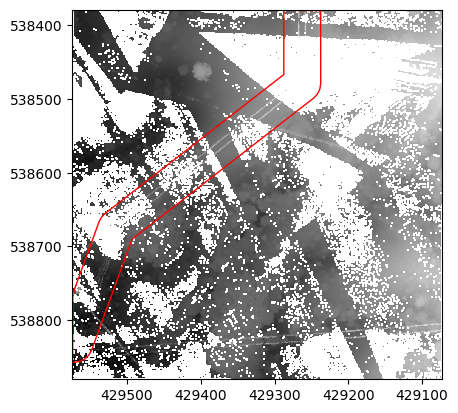

In [339]:
# criar o objeto Axes
fig, ax = plt.subplots()

# plotar o raster no objeto Axes
rasterio.plot.show(raster, ax=ax, cmap='gray')

# plotar a shape no mesmo objeto Axes
shape.plot(ax=ax, facecolor='none', edgecolor='red')

# mostrar o plot
plt.show()

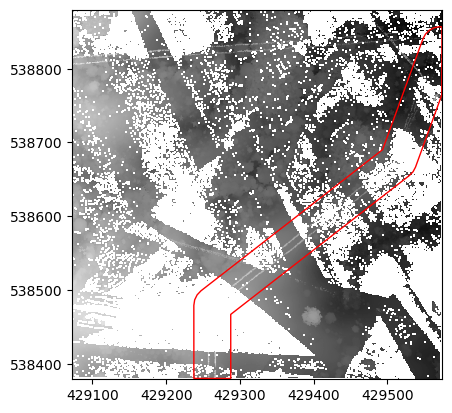

In [341]:
# Inverter os eixos X e Y para os corretos, bem georreferenciados
fig, ax = plt.subplots()

# plotar o raster no objeto Axes
rasterio.plot.show(raster, ax=ax, cmap='gray')

# plotar a shape no mesmo objeto Axes
shape.plot(ax=ax, facecolor='none', edgecolor='red')

# inverter o eixo y
ax.invert_yaxis()

# inverter o eixo x
ax.invert_xaxis()

# mostrar o plot
plt.show()